In [1]:
import os
import scipy.io
import numpy as np
from scipy import signal

data_path = "/kaggle/input/control1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250

control_data = []
control_path = os.path.join(data_path, 'Control')

for foldername in os.listdir(control_path):
    subfolder_path = os.path.join(control_path, foldername)
    control_data.append(subfolder_path)

Control30 = []

for control_data_path in control_data:
    n_epochs = 70 
    start_epoch = 1
    end_epoch = 110

    control_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = os.path.join(control_data_path, f"trial{i}.mat")
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]    
        #print(mat_data1.shape)
        # Downsampling
        num_samples_original = mat_data1.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(mat_data1, num_samples_new, axis=-1)
        #print(downsampled_data.shape)
        
        control_arr.append(downsampled_data)
        Control30.append(downsampled_data)

Control30 = np.array(Control30)

print(Control30.shape)


(3300, 60, 1000)


In [2]:
import os
import scipy.io
import numpy as np
from scipy import signal
data_path = "/kaggle/input/concussed1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250  

concussed_data = []
concussed_path = os.path.join(data_path, 'Concussed')
for foldername in os.listdir(concussed_path):
    subfolder_path = os.path.join(concussed_path, foldername)
    concussed_data.append(subfolder_path)

Concussed52 = []
for concussed_data_path in concussed_data:
    n_epochs = 70
    start_epoch = 1
    end_epoch = 110
    concussed_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = f"{concussed_data_path}/trial{i}.mat"
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        num_samples_original = mat_data1.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(mat_data1, num_samples_new, axis=-1)
        
        concussed_arr.append(np.array(downsampled_data))
        
        Concussed52.append(downsampled_data)

Concussed52 = np.array(Concussed52)

print( Concussed52.shape)


(5390, 60, 1000)


In [3]:
dataset = np.concatenate((Control30, Concussed52), axis=0)
labels = np.concatenate((np.zeros(Control30.shape[0]), np.ones(Concussed52.shape[0])))

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

k = 5  
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []  
val_losses = []  
train_accs = []  
val_accs = []  
cm_sum = np.zeros((2, 2))

for train_index, val_index in skf.split(dataset, labels):
    X_train_fold, X_val = dataset[train_index], dataset[val_index]
    y_train_fold, y_val = labels[train_index], labels[val_index]

    X_train_fold_norm = (X_train_fold - mean) / std
    X_val_norm = (X_val - mean) / std

    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(60, 1000)))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train_fold_norm, y_train_fold, validation_data=(X_val_norm, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

    loss, accuracy = model.evaluate(X_val_norm, y_val)
    print(f'Fold Loss: {loss:.4f}')
    print(f'Fold Accuracy: {accuracy:.4f}')

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accs.append(history.history['accuracy'])
    val_accs.append(history.history['val_accuracy'])

    X_test_norm = (X_test - mean) / std
    y_pred = model.predict(X_test_norm)
    y_pred_classes = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_classes)
    cm_sum += cm

train_losses = np.concatenate(train_losses)
val_losses = np.concatenate(val_losses)
train_accs = np.concatenate(train_accs)
val_accs = np.concatenate(val_accs)


Epoch 1/100
218/218 [==============================] - 7s 28ms/step - loss: 0.6449 - accuracy: 0.6484 - val_loss: 0.5698 - val_accuracy: 0.6910
Epoch 2/100
218/218 [==============================] - 5s 24ms/step - loss: 0.5267 - accuracy: 0.7386 - val_loss: 0.5309 - val_accuracy: 0.7146
Epoch 3/100
218/218 [==============================] - 5s 24ms/step - loss: 0.4844 - accuracy: 0.7650 - val_loss: 0.4994 - val_accuracy: 0.7486
Epoch 4/100
218/218 [==============================] - 5s 24ms/step - loss: 0.4122 - accuracy: 0.8116 - val_loss: 0.4641 - val_accuracy: 0.7727
Epoch 5/100
218/218 [==============================] - 5s 24ms/step - loss: 0.3487 - accuracy: 0.8475 - val_loss: 1.3822 - val_accuracy: 0.6858
Epoch 6/100
218/218 [==============================] - 5s 25ms/step - loss: 0.3471 - accuracy: 0.8521 - val_loss: 0.5607 - val_accuracy: 0.7693
Epoch 7/100
218/218 [==============================] - 5s 25ms/step - loss: 0.2843 - accuracy: 0.8836 - val_loss: 0.4395 - val_accuracy:

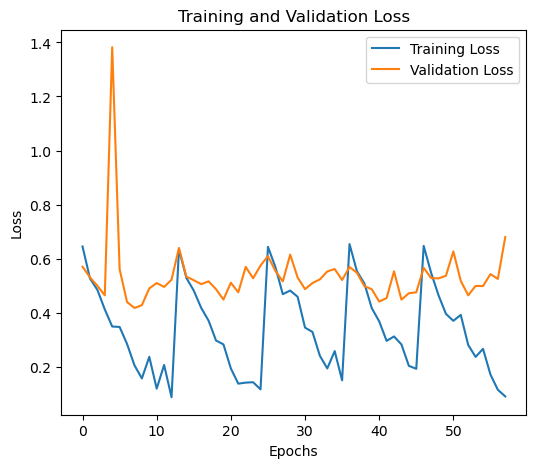

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

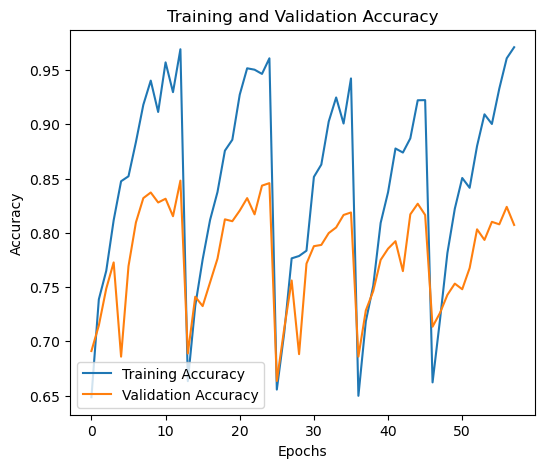

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [17]:
target_names = ['Control', 'Concussed']
from sklearn.metrics import classification_report, confusion_matrix

threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

print(classification_report(y_test, y_pred_binary, target_names=target_names))



              precision    recall  f1-score   support

     Control       0.82      0.56      0.67       684
   Concussed       0.76      0.92      0.83      1054

    accuracy                           0.78      1738
   macro avg       0.79      0.74      0.75      1738
weighted avg       0.79      0.78      0.77      1738



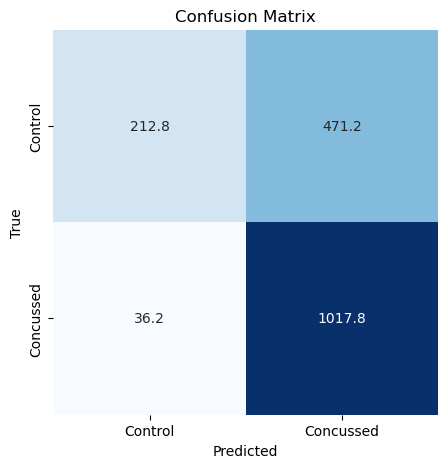

In [18]:
import seaborn as sns

cm_avg = cm_sum / k
plt.figure(figsize=(6, 5))
sns.heatmap(cm_avg, annot=True, cmap='Blues', fmt='g', cbar=False, square=True,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy

delta_band = (0.5, 4)
alpha_band = (8, 12)
beta_band = (12, 35)

all_control_power = []
scaler = MinMaxScaler()
epsilon = 1e-10

# Normalizing the features
for i in range(len(Control30)):
    control_data = Control30[i]
    control_power = []
    for epoch in control_data:
        epoch_power = []
        for channel_data in epoch:
            freq_spectrum = np.fft.fft(channel_data)
            power_spectrum = np.abs(freq_spectrum) ** 2

            alpha_power = np.sum(power_spectrum[(alpha_band[0] <= freq_spectrum) & (freq_spectrum <= alpha_band[1])])
            beta_power = np.sum(power_spectrum[(beta_band[0] <= freq_spectrum) & (freq_spectrum <= beta_band[1])])
            delta_power = np.sum(power_spectrum[(delta_band[0] <= freq_spectrum) & (freq_spectrum <= delta_band[1])])

            channel_min_value = np.min(channel_data)
            channel_max_value = np.max(channel_data)
            power_spectrum_adjusted = power_spectrum + epsilon
            entropy_values = entropy(power_spectrum_adjusted)
            values=np.array([alpha_power,beta_power,delta_power,entropy_values])
            rescaled_values = (values - values.min()) * (channel_max_value - channel_min_value) / (values.max() - values.min()) + channel_min_value
            concatenated_data = np.concatenate((channel_data, rescaled_values))
            epoch_power.append(concatenated_data.tolist())

        control_power.append(np.array(epoch_power))

    all_control_power.append(np.array(control_power))

all_control_power = np.array(all_control_power)
print(all_control_power.shape)
print(len(Control30))
